_Author: Piotr Kaniewski; Date 04.03.2025_

# ROBOKOP, RTX-KG2, and Integrated KG - Matrix & Model Benchmark
This report is comparing metrics obtained using topological embeddings from three different KGs. All the embeddings were generated using the same method. 

KGs can be found here:
* Integrated KG Release: _mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.4/datasets/integration/prm/filtered_
* RTX-KG2 Release: _mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.5/datasets/matrix/prm/filtered_
* ROBOKOP Release: _mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.6/datasets/matrix/prm/filtered_

MLFlow runs can be found here (within cross-kg experiment):
* Integrated KG: [modelling-test-run-rtx-robokop-fixed-98867342 ](https://mlflow.platform.dev.everycure.org/#/experiments/18077/runs/92e1c98a68374cc8988fa02c170eccbd)
* RTX-KG2: [modelling-test-run-rtx-1fff2ef7](https://mlflow.platform.dev.everycure.org/#/experiments/18077/runs/07b9978ded5b4c6299a8c0406893876a)
* ROBOKOP: [modelling-test-run-robokop-27a5a15d ](https://mlflow.platform.dev.everycure.org/#/experiments/18077/runs/1aa98ae44358469d8e747ca7d07dfacb)

**TL;DR**
* **At the moment, integration of ROBOKOP and RTX-KG2 is not improving/yielding better results than using RTX-KG2 alone. This is expected as we can say RTX-KG2 and GT are curated for this purpose, and ROBOKOP has very different topology and is dervied from different sources than KGML-xDTD ground truth. However we do get 14m pairs in the MATRIX due to better coverage of ROBOKOP.**
* **The difference in performance is large on the standard GT but it is much smaller when dealing with off-label dataset (and ROBOKOp actually outperforms integrated RTX-KG2 on that dataset). For clinical Trials dataset, the difference is negligible but there is no clear improvement over RTX-KG2 alone - indicating that all these KGs perform similarly when trying on unseen dataset.**
* **When it comes to negativee recall @ n and other negative metrics - ROBOKOP and integrated KG actually perform a bit better than RTX-KG2. This potentially indicates that RTX-KG2 is a bit more noisy/less biologically reliable than ROBOKOP. However the difference small in this case.**
* **Examination of the embedding convergence plots indicates that one of the reasons for lower quality of classifiers might be lower quality of embeddings (bearing in mind that quality is correlated with loss).**







In [3]:
import polars as pl
import yaml as yaml
from PIL import Image
from google.cloud import storage

# Background on KG mapping
Bringing images from the analysis done in tabular comparison notebook which can be found [here](https://github.com/everycure-org/lab-notebooks/blob/main/KG_EDA/rtx_kg2_robokop/tabular_comparison.ipynb)

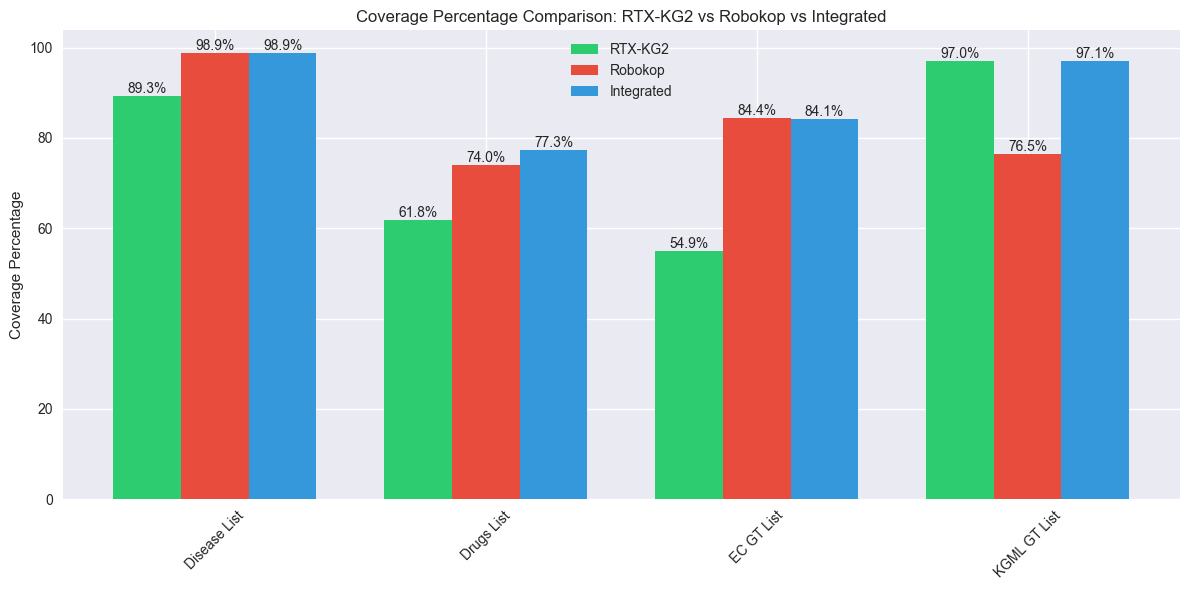

In [3]:
from PIL import Image

Image.open('kg_comparison_dataset_percentage.png')

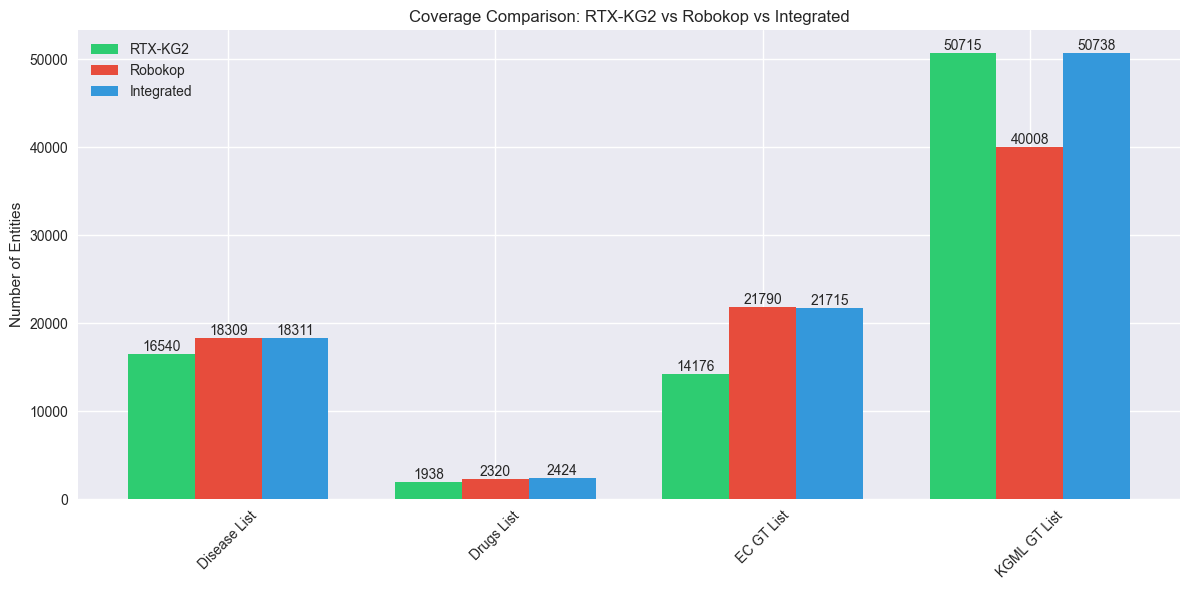

In [110]:
from PIL import Image

Image.open('scratch/kg_comparison_datasets_absolute.png')

So with ROBOKOP/Integrated KG we definitely get:
* greater coverage of disease list - 1769 more diseases
* greater coverage of drugs - 382 drugs
* greater coverage of drug-disease pairs from EC ground truth (old version) - 7614 pairs 
* 20% smaller coverage of KGML-xDTD ground truth - 10k pairs lost

# MLflow Metrics comparison 
_For full code reproduction see the notebooks in [lab-notebooks](https://github.com/everycure-org/lab-notebooks/blob/main/cross-kg-modelling/benchmark_kg_matrices.ipynb):_


In [22]:
rtx_df = pl.DataFrame(rtx_metrics)
robo_df = pl.DataFrame(robo_metrics)
int_df = pl.DataFrame(int_metrics)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

def highlight_min(s):
    is_max = s == s.min()
    return ['background-color: red' if v else '' for v in is_max]


pl.Config.set_tbl_rows(40)
df = pl.concat([rtx_df, robo_df, int_df]).transpose(include_header=True, header_name='metric', column_names=['rtx', 'robo', 'int'])
df.to_pandas().set_index('metric').style.apply(highlight_max, axis=1).apply(highlight_min,axis=1)

,rtx,robo,int
metric,,,
auroc,0.994978,0.981915,0.990343
recall-1000,0.169912,0.070785,0.111627
recall-10000,0.513274,0.314648,0.436252
recall-100000,0.821239,0.650123,0.767657
recall-1000000,0.964602,0.875096,0.932200
accuracy_score,0.894643,0.835514,0.890460
f1_score,0.860796,0.768118,0.857456
hit-10,0.581084,0.422612,0.567116
hit-100,0.856917,0.743339,0.851911


However these are not fully comparable due to different ground truth sets being used. MLFlow metrics (can be found [here](https://mlflow.platform.dev.everycure.org/#/experiments/18077/runs/1aa98ae44358469d8e747ca7d07dfacb)) show that only 67% of negative pairs and 66% of positive pairs were retained and used for training. Let's compare the same ground truth set for all three models.

In [34]:
robo_df = pl.DataFrame(robo_metrics)
int_df = pl.DataFrame(int_metrics)
rtx_df_same_gt = pl.DataFrame(rtx_metrics_same_gt)
int_df_same_gt = pl.DataFrame(int_metrics_same_gt)


def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

def highlight_min(s):
    is_max = s == s.min()
    return ['background-color: red' if v else '' for v in is_max]


pl.Config.set_tbl_rows(40)
df = pl.concat([robo_df, rtx_df_same_gt, int_df_same_gt]).transpose(include_header=True, header_name='metric', column_names=['robo','rtx_same', 'int_same'])
df.to_pandas().set_index('metric').style.apply(highlight_max, axis=1).apply(highlight_min,axis=1)

,robo,rtx_same,int_same
metric,,,
auroc,0.981915,0.989635,0.989033
recall-1000,0.070785,0.139498,0.099235
recall-10000,0.314648,0.453704,0.396403
recall-100000,0.650123,0.761842,0.752129
recall-1000000,0.875096,0.939541,0.919264
accuracy_score,0.835514,0.878925,0.887628
f1_score,0.768118,0.837029,0.851654
hit-10,0.422612,0.560572,0.551058
hit-100,0.743339,0.841375,0.843626


As expected: when using even a subset of KGML-xDTD Ground Truth, models trained on RTX-KG2 ground truth perform much better. This makes sense as KGML-XDTD ground truth is derived from the same data sources as KG2.

# Matrix Comparison

In [50]:
rtx_matrix = pl.read_parquet('gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.5/runs/modelling-test-run-rtx-1fff2ef7/datasets/matrix_generation/model_output/fold_3/matrix_predictions')
integrated_matrix = pl.read_parquet('gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.4/runs/modelling-test-run-rtx-robokop-fixed-98867342/datasets/matrix_generation/model_output/fold_3/matrix_predictions')
robokop_matrix = pl.read_parquet('gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.6/runs/modelling-test-run-robokop-27a5a15d/datasets/matrix_generation/model_output/fold_3/matrix_predictions')

# matrices trained on the same set as ROBOKOP
rtx_matrix_same_gt = pl.read_parquet('gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.5/runs/modelling-test-rtx-same-gt-f2eb9c9c/datasets/matrix_generation/model_output/fold_3/matrix_predictions')
integrated_matrix_same_gt = pl.read_parquet('gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.4/runs/modelling-test-integrated-same-gt-732d1c28/datasets/matrix_generation/model_output/fold_3/matrix_predictions')


In [51]:
rtx_matrix[['treat score','not treat score', 'unknown score']].head(100000).describe()

statistic,treat score,not treat score,unknown score
str,f64,f64,f64
"""count""",100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.676727,0.02308,0.300192
"""std""",0.18952,0.066678,0.187952
"""min""",0.401765,7.8136e-10,1.6910e-7
"""25%""",0.506029,0.000043,0.125801
"""50%""",0.647937,0.000594,0.318769
"""75%""",0.847177,0.008064,0.468921
"""max""",1.0,0.597983,0.598231


In [52]:
rtx_matrix_same_gt[['treat score','not treat score', 'unknown score']].head(100000).describe()

statistic,treat score,not treat score,unknown score
str,f64,f64,f64
"""count""",100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.673438,0.02273,0.303831
"""std""",0.181472,0.064789,0.180773
"""min""",0.418365,1.1938e-9,0.000001
"""25%""",0.512328,0.00005,0.14052
"""50%""",0.64045,0.000633,0.328003
"""75%""",0.828421,0.008326,0.464118
"""max""",0.999999,0.577026,0.581611


In [53]:
robokop_matrix[['treat score','not treat score', 'unknown score']].head(100000).describe()

statistic,treat score,not treat score,unknown score
str,f64,f64,f64
"""count""",100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.730736,0.018767,0.250497
"""std""",0.158795,0.056229,0.158819
"""min""",0.495575,4.2541e-12,0.000002
"""25%""",0.588488,0.000018,0.10065
"""50%""",0.707526,0.000329,0.264113
"""75%""",0.874259,0.005498,0.393348
"""max""",0.999998,0.496885,0.504425


In [54]:
integrated_matrix[['treat score','not treat score', 'unknown score']].head(100000).describe()

statistic,treat score,not treat score,unknown score
str,f64,f64,f64
"""count""",100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.735477,0.020956,0.243566
"""std""",0.164824,0.058236,0.162627
"""min""",0.482613,2.0848e-9,2.4859e-7
"""25%""",0.585496,0.000077,0.088632
"""50%""",0.71977,0.000784,0.247395
"""75%""",0.889514,0.008636,0.389649
"""max""",1.0,0.512269,0.51735


In [55]:
integrated_matrix_same_gt[['treat score','not treat score', 'unknown score']].head(100000).describe()

statistic,treat score,not treat score,unknown score
str,f64,f64,f64
"""count""",100000.0,100000.0,100000.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.750962,0.020208,0.22883
"""std""",0.15843,0.056611,0.156692
"""min""",0.505402,5.7489e-10,6.0265e-8
"""25%""",0.607131,0.000037,0.0775
"""50%""",0.73732,0.000554,0.23095
"""75%""",0.90122,0.007655,0.369733
"""max""",1.0,0.493272,0.494571


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

dict = {'integrated_matrix':integrated_matrix.to_pandas(), 'rtx_matrix':rtx_matrix.to_pandas(), 'robokop_matrix':robokop_matrix.to_pandas()}

def score_distribution(k: int=None, **dfs):
    """
    Plot distribution of scores for each model.
    
    Generates two plots:
    1. Overlapping histograms for all models.
    2. Separate subplots for each model's histogram.
    """
    if k is not None:
        dfs = {name: df.iloc[:k, :] for name, df in dfs.items()}
    # Overlapping histograms
    fig1 = plt.figure(figsize=(10, 6))
    for model in dfs.keys():
        sns.histplot(dfs[model]['treat score'], bins=100, kde=False, alpha=0.3, label=model, fill=True)
    plt.yscale('log')
    plt.xlabel('Scores')
    plt.ylabel('Frequency (log scale)')
    plt.title('Distribution of Scores for Full Matrix (Overlapping)')
    plt.legend()
    
    # Separate subplots
    num_models = len(dfs)
    fig2, axes = plt.subplots(num_models, 1, figsize=(5, 3 * num_models), sharex=True, sharey=True)
    for ax, (model, data) in zip(axes, dfs.items()):
        sns.histplot(data['treat score'], bins=100, kde=False, alpha=0.3, label=model, fill=True, ax=ax)
        ax.set_yscale('log')
        ax.set_xlabel('Scores')
        ax.set_ylabel('Frequency (log scale)')
        ax.set_title(f'Distribution of Scores for {model}')
        ax.legend()
    
    plt.tight_layout()
    return fig1, fig2

score_distribution(k=None, **dict)

(<Figure size 1000x600 with 1 Axes>, <Figure size 500x900 with 3 Axes>)

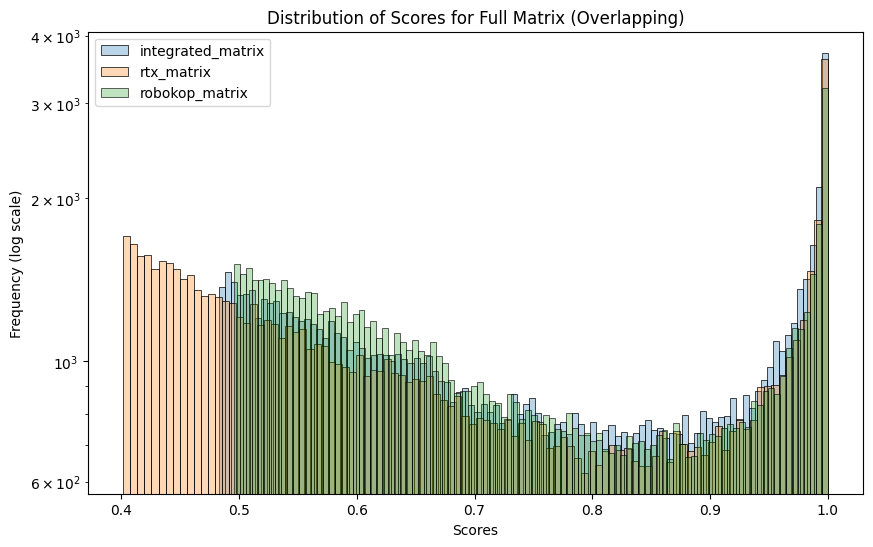

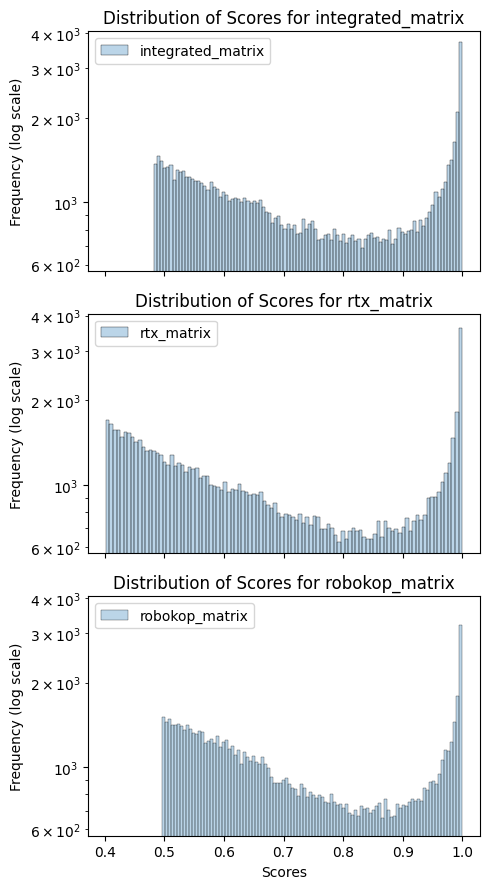

In [19]:
score_distribution(k=100000, **dict)

We can see that when it comes to distribution of scores, the models are very similar; the shape is consistent with all other XG-Ensemble models that we observed in the past. Meaning that distribution of scores is actually classifier dependendent; the slightly different range can be due to randomness and also some tiny embedding differences but it's quite negligible

# Model Performance Visualisations

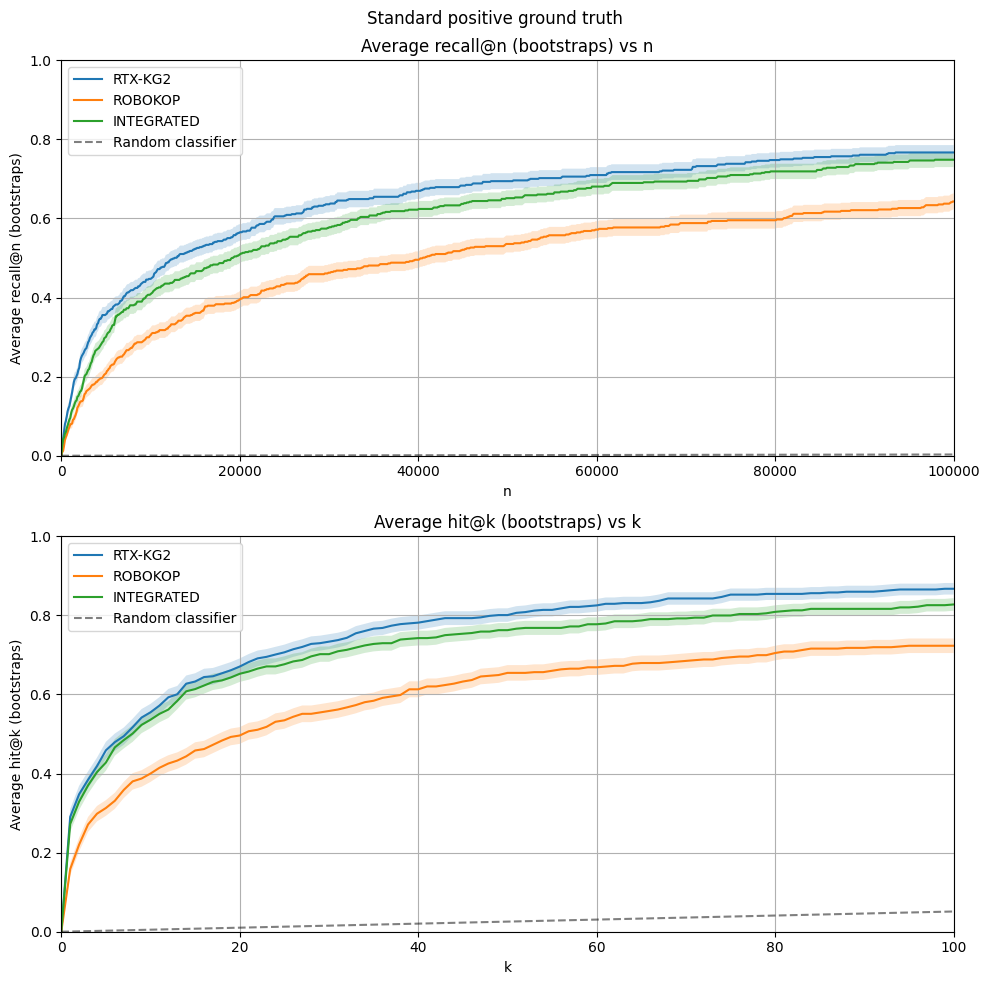

In [47]:
plot_av_ranking_metrics(
    (rtx_matrices[0], robo_matrices[0], int_matrices[0]),
    ('RTX-KG2', 'ROBOKOP', 'INTEGRATED'),
    bool_test_col = 'is_known_positive',
    score_col='treat score',
    perform_sort = False,
    sup_title = "Standard positive ground truth",
    is_average_bootstraps = True
)

Very similar performance between RTX-KG2 and integrated KG. Not necessarily surprising as
* KGML-xDTD ground truthis designed for RTX-KG2
* RTX-KG2 is much less dense than ROBOKOP - thus our embedding method, random walk initialization etc will need to adjust accordingly
* We dont apply much filtering to ROBOKOP compared to many filters applied to RTX-KG2; the only filters we apply to ROBOKOP are RTX-KG2 specific.

In short, we can't say for sure what is causing the performance drop but it's likely due to both embeddings quality AND filtering of KG2.

ACTIONS:
 * Develop Initial Filters for ROBOKOP
 * (Stretch) repeat RTX-KG2 experiment with full non filtered KG2
 * Find most optimal N2V parameters for robokop or other embedding method (comeback to GraphSAGE or experiment more)

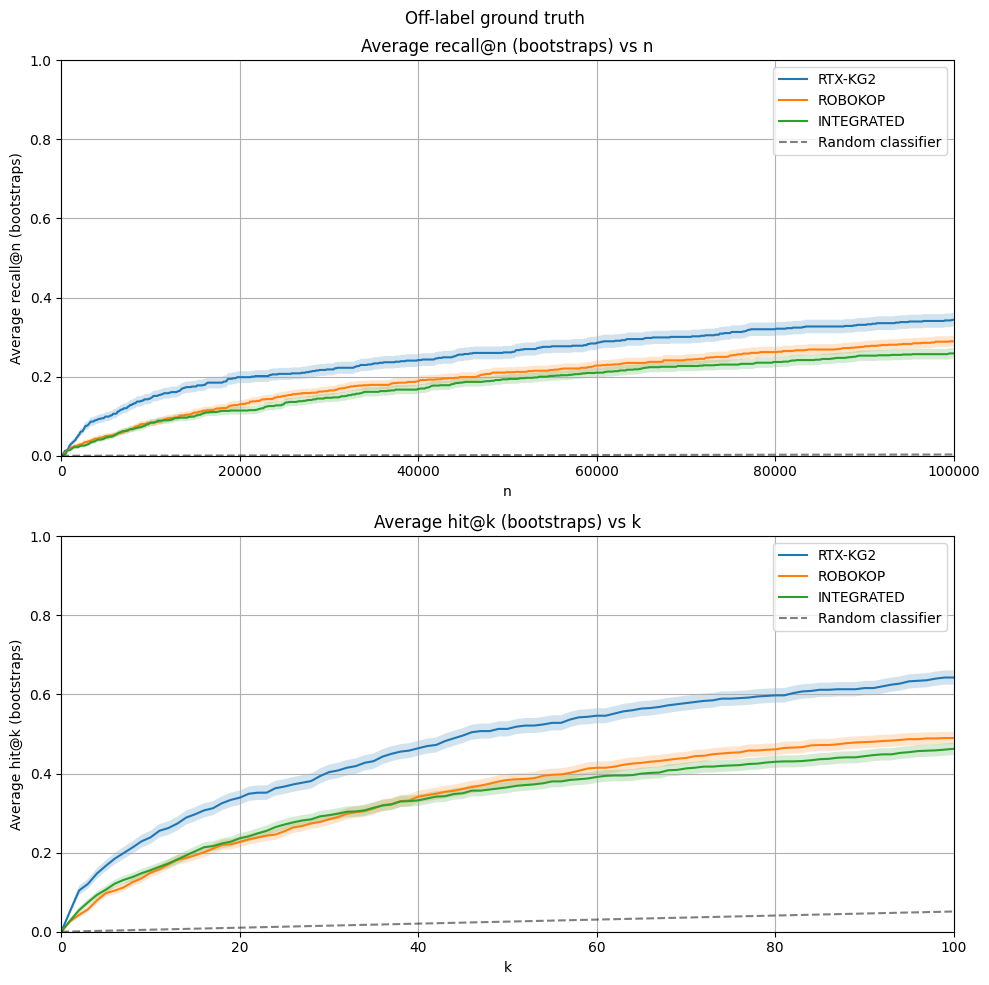

In [49]:
plot_av_ranking_metrics(
    (rtx_matrices[0], robo_matrices[0], int_matrices[0]),
    ('RTX-KG2', 'ROBOKOP', 'INTEGRATED'),
    bool_test_col = 'is_off_label',
    score_col='treat score',
    perform_sort = False,
    sup_title = "Off-label ground truth",
    is_average_bootstraps = True
)

Interesting - ROBOKOP performs better on off-label dataset than integrated KG; RTX-KG2 still outperforms remaining two but this is likely due to the reasons explained above. 

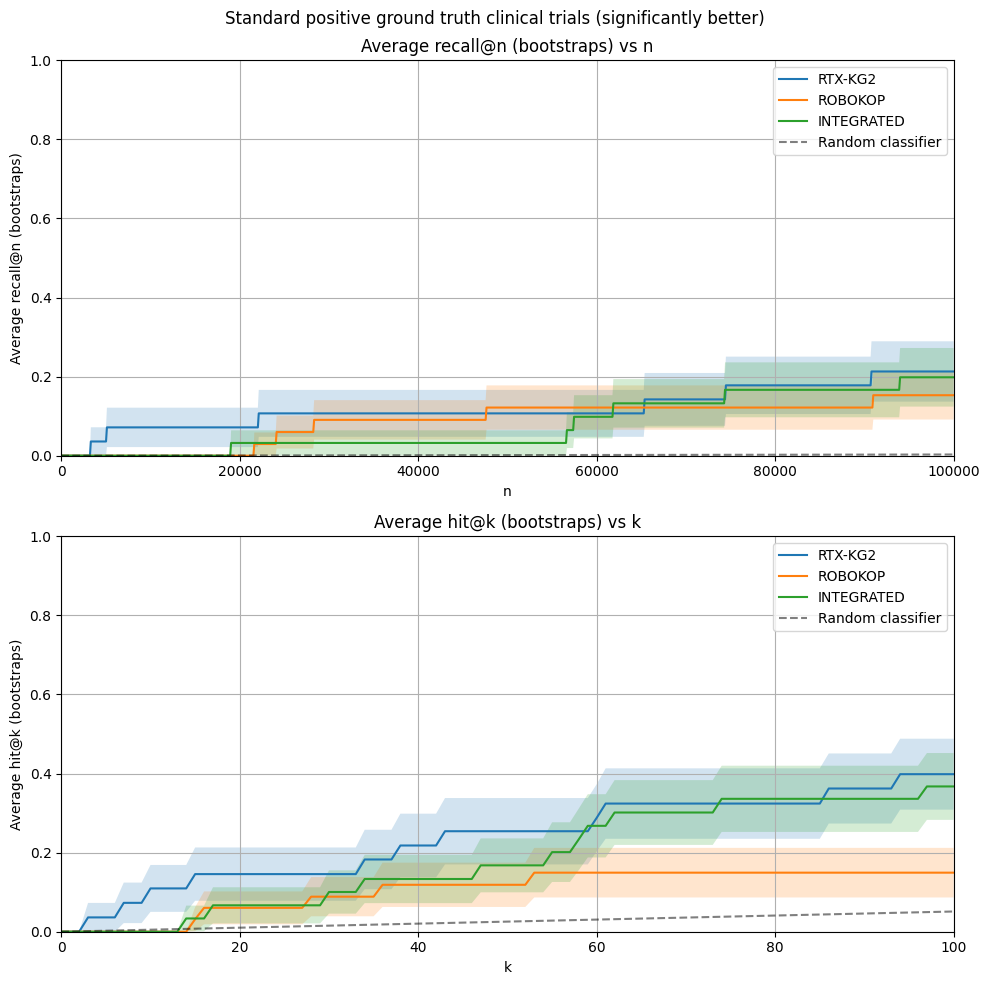

In [50]:
plot_av_ranking_metrics(
    (rtx_matrices[0], robo_matrices[0], int_matrices[0]),
    ('RTX-KG2', 'ROBOKOP', 'INTEGRATED'),
    bool_test_col = 'trial_sig_better',
    score_col='treat score',
    perform_sort = False,
    sup_title = "Standard positive ground truth clinical trials (significantly better)",
    is_average_bootstraps = True
)

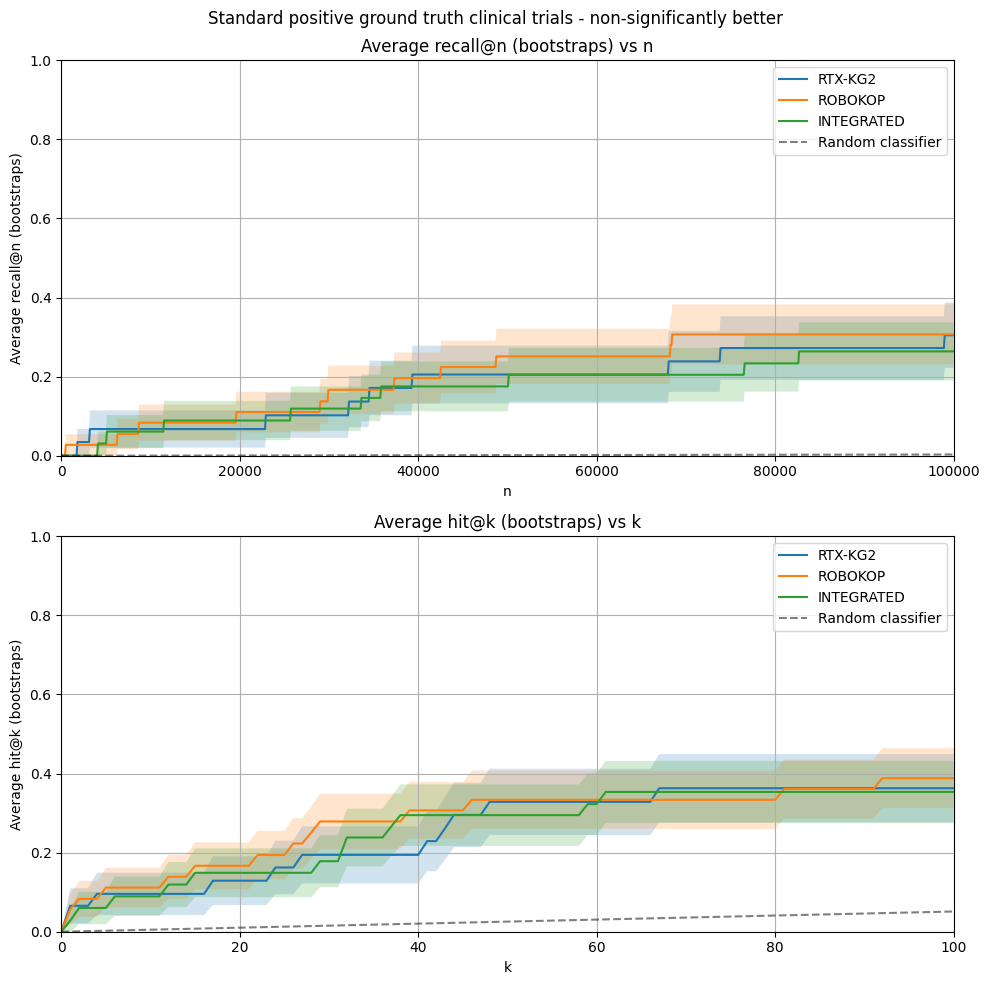

In [51]:
plot_av_ranking_metrics(
    (rtx_matrices[0], robo_matrices[0], int_matrices[0]),
    ('RTX-KG2', 'ROBOKOP', 'INTEGRATED'),
    bool_test_col = 'trial_non_sig_better',
    score_col='treat score',
    perform_sort = False,
    sup_title = "Standard positive ground truth clinical trials - non-significantly better",
    is_average_bootstraps = True
)

None of the models outperform the rest significantly when it comes to clinical trials dataset. This potentially indicates that none of the models actually predict pairs from unseen clinical test set. As the performance is consistent across the KGs, this is most likely due to KGML-xDTD GT not capturing clinical trials data well enough

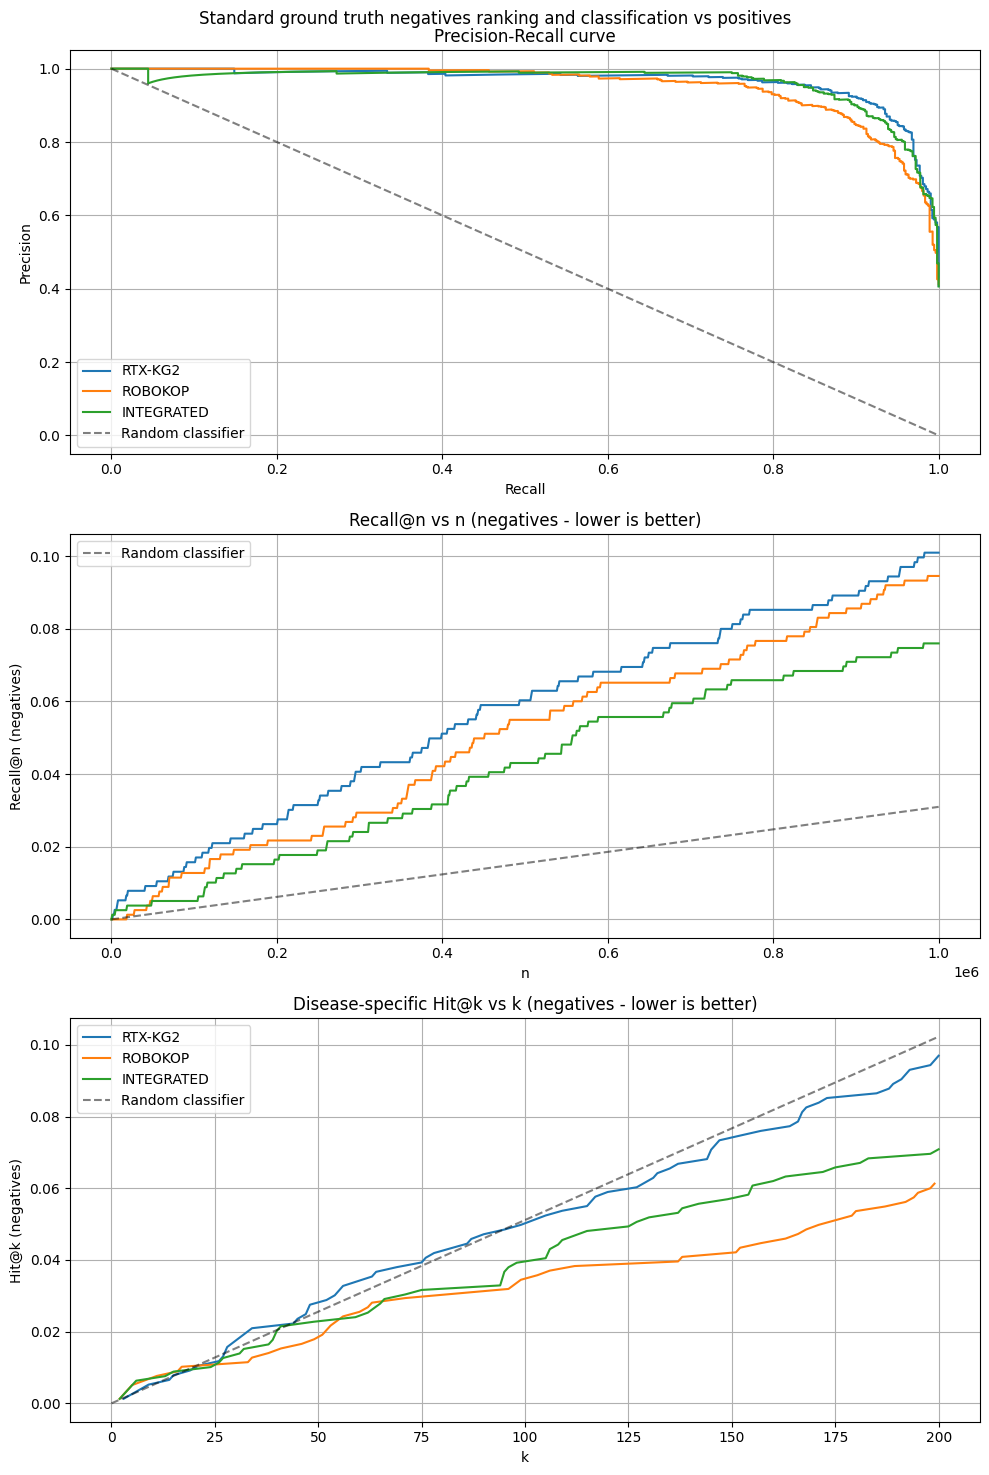

In [39]:
plot_negative_metrics(
    (rtx_matrices[0], robo_matrices[0], int_matrices[0]),
    ("RTX-KG2", "ROBOKOP", "INTEGRATED"),
    bool_pos_col = "is_known_positive",
    bool_neg_col = "is_known_negative",
    score_col = "treat score",
    perform_sort = False,
    sup_title = "Standard ground truth negatives ranking and classification vs positives"
)

Both integrated KG and ROBOKOp actually seem to perform better when it comes to negative metrics; this *could* indicate that RTX-KG2 is a bit more noisy/less biologically reliable than ROBOKOP. However the difference small in this case.

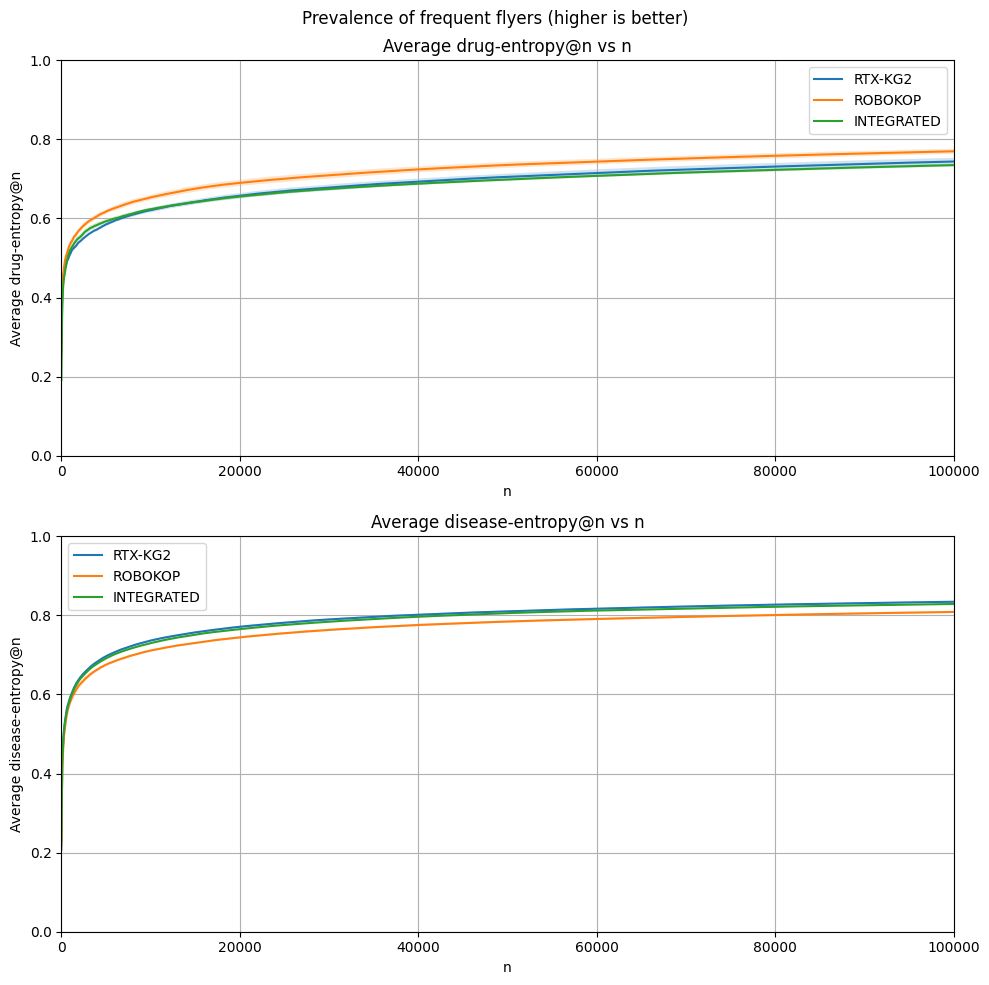

In [40]:
plot_av_entropy(
    (rtx_matrices, robo_matrices, int_matrices),
    ("RTX-KG2", "ROBOKOP", "INTEGRATED"),
    score_col = "treat score",
    perform_sort = False,
    sup_title = "Prevalence of frequent flyers (higher is better)"
)

ROBOKOP also has fewer frequent flyer drugs but a bit more frequent flyer diseases. If we can pin down the issue of frequet flyer/loser to connectivity, then this would indicate that drugs are not as densely connected but diseases are for ROBOKOP. 

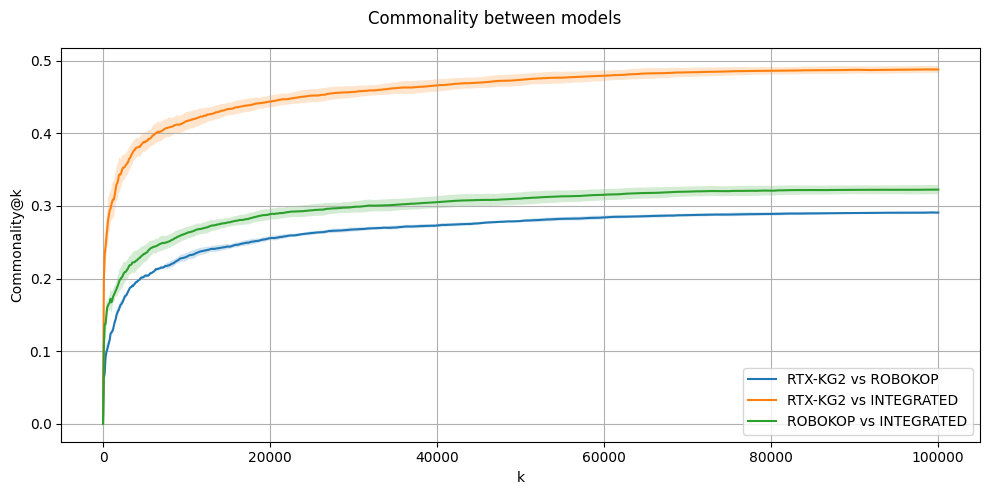

In [41]:
plot_commonality_between_models(
    (rtx_matrices, robo_matrices, int_matrices),
    ('RTX-KG2', 'ROBOKOP', 'INTEGRATED'),
    score_col='treat score',
    perform_sort = False,
    sup_title = "Commonality between models"
)

We can say: there is a correlation between the model performance and the number of pairs which are scoring highly. This plot is consistent with ROBOKOP performing more poorly than RTX-KG2 and integrated KG, especially bearing in mind that different train set was used for ROBOKOP

# Trobuleshoot - is it embeddings or KG itself?
with many variables between the KGs and MATRIX predictions, it's difficult to pinpoint a single reason for poor quality for our integrated KG. One of the first thing coming to mind is embedding quality: let's look at PCA and convergence plots generated by each embedding model

## Convergence Plots

Convergence Plot for ROBOKOP


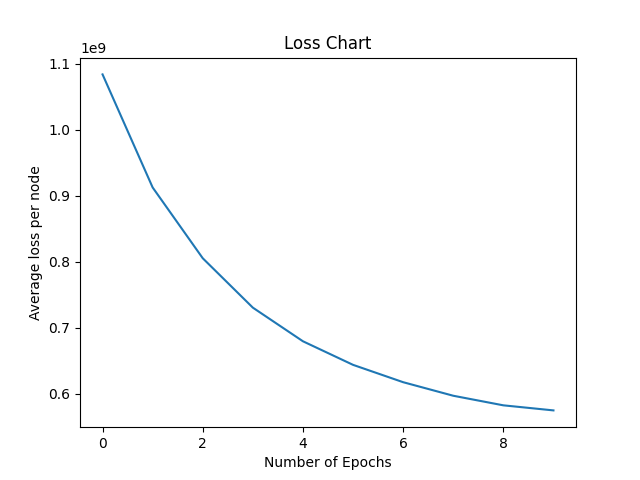

Convergence Plot for RTX-KG2


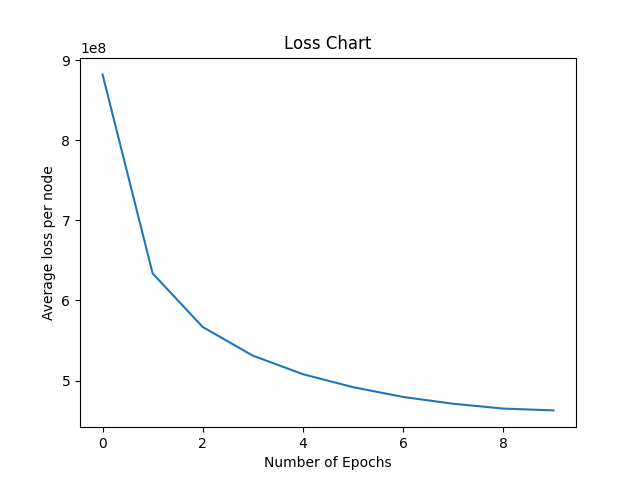

Convergence Plot for Integrated KG


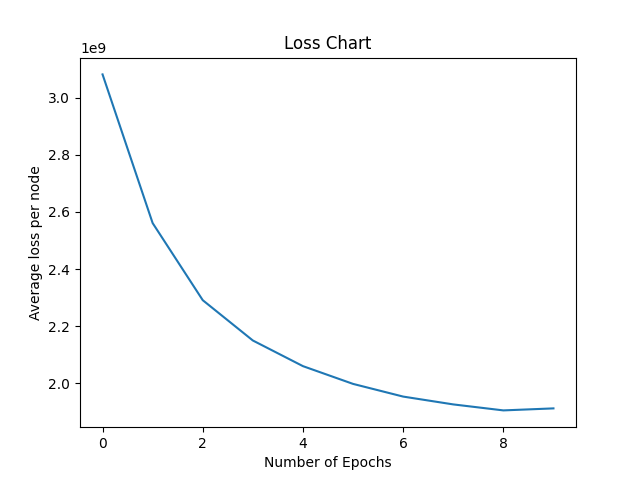

In [63]:
import gcsfs

# Download file from GCS
fs = gcsfs.GCSFileSystem()
gcs_path = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.6/runs/release-with-robo-medical-455d80fe/mlflow/855f04b2ae2543baa024e6f77c118ced/artifacts/topological/convergence_plot.png'
local_path_robokop = '/tmp/convergence_plot_robokop.png'
fs.get(gcs_path, local_path_robokop)

gcs_path = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.5/runs/release-with-rtx-medical-7f4a0317/mlflow/b9836a192d984963a7d93f426174561d/artifacts/topological/convergence_plot.png'
local_path_rtx = '/tmp/convergence_plot_rtx.png'
fs.get(gcs_path, local_path_rtx)

gcs_path = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.4/runs/release-with-rtx-robo-medical-bfea1cc8/mlflow/cff19c72d1284511af6364c019abcc71/artifacts/topological/convergence_plot.png'
local_path_int = '/tmp/convergence_plot_int.png'
fs.get(gcs_path, local_path_int)

# Open downloaded file
print('Convergence Plot for ROBOKOP')
display(Image.open(local_path_robokop))
print('Convergence Plot for RTX-KG2')
display(Image.open(local_path_rtx))
print('Convergence Plot for Integrated KG')
display(Image.open(local_path_int))

So We are reaching much lower (10x) loss per node when having ROBOKOP and RTX-KG2. We can't say the loss achieved during embedding optimization is directly proportional not directly proportional to the performance of the model but it's a good hint for further investigation; we can also observe that PCA of embeddings look much different than what they looked like initially.

Convergence Plot for ROBOKOP


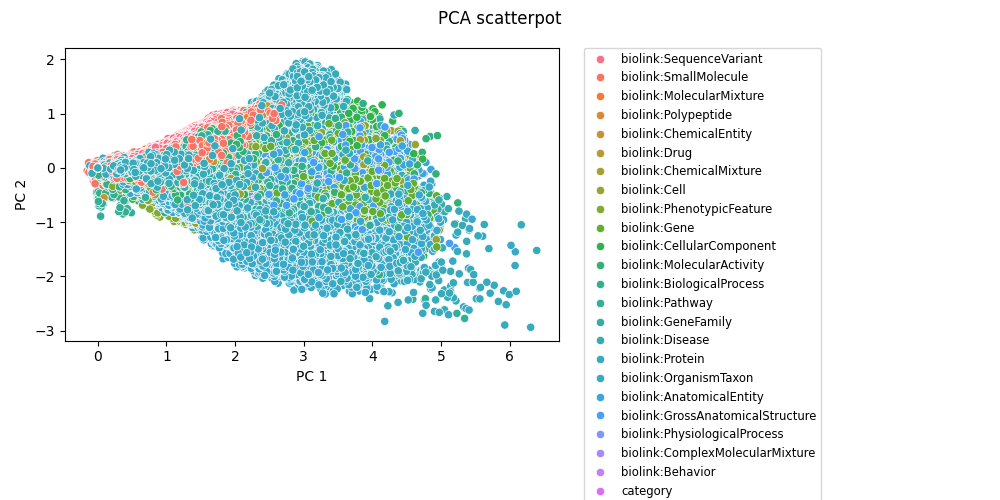

Convergence Plot for RTX-KG2


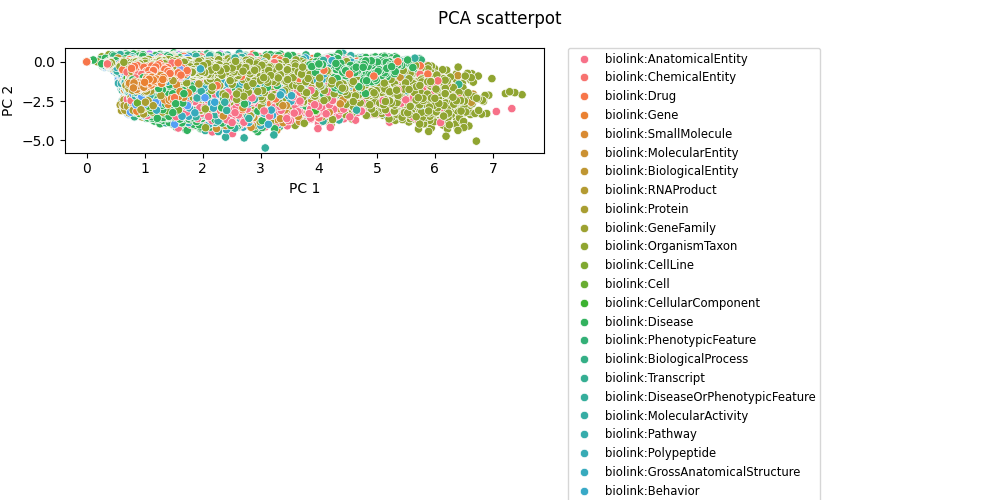

Convergence Plot for Integrated KG


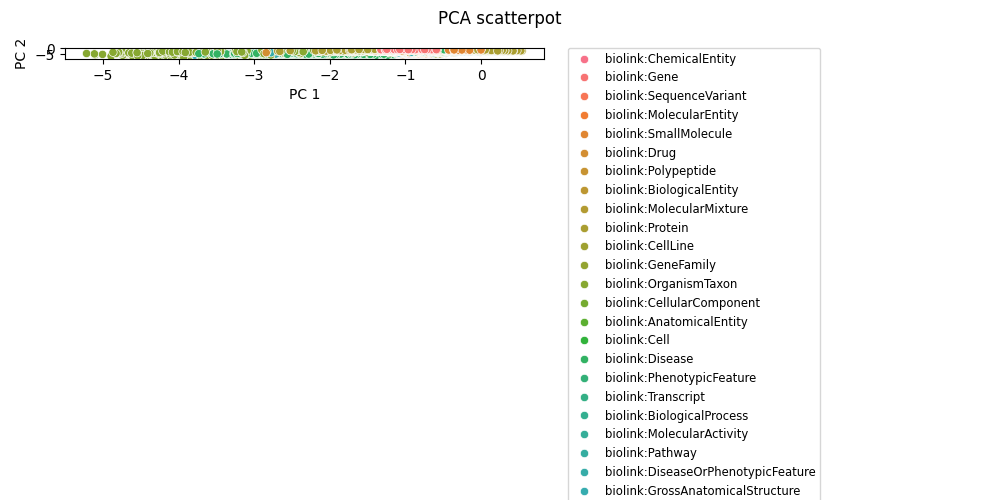

In [64]:
import gcsfs

# Download file from GCS
fs = gcsfs.GCSFileSystem()
gcs_path = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.6/runs/release-with-robo-medical-455d80fe/mlflow/855f04b2ae2543baa024e6f77c118ced/artifacts/topological/pca_plot.png'
local_path_robokop = '/tmp/pca_plot_robokop.png'
fs.get(gcs_path, local_path_robokop)

gcs_path = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.5/runs/release-with-rtx-medical-7f4a0317/mlflow/b9836a192d984963a7d93f426174561d/artifacts/topological/pca_plot.png'
local_path_rtx = '/tmp/pca_plot_rtx.png'
fs.get(gcs_path, local_path_rtx)

gcs_path = 'gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.3.4/runs/release-with-rtx-robo-medical-bfea1cc8/mlflow/cff19c72d1284511af6364c019abcc71/artifacts/topological/pca_plot.png'
local_path_int = '/tmp/pca_plot_int.png'
fs.get(gcs_path, local_path_int)

# Open downloaded file
print('Convergence Plot for ROBOKOP')
display(Image.open(local_path_robokop))
print('Convergence Plot for RTX-KG2')
display(Image.open(local_path_rtx))
print('Convergence Plot for Integrated KG')
display(Image.open(local_path_int))

Formatting went wrong for integrated KG. PCA plots don't look instantly off (no weird shapes as in case of GraphSAGE back in August 2024) and both could be correct. We could hypothesize that current embedding method brings similar concepts closer together (similar concepts do not necessarily mean categories will be clustered appropriately; the clustering is done based on topology). However we would need to interact with the embeddings to be sure.

ACTION: 
* In-depth exploratory analysis of embeddings
* Experimenting with different embedding methods to bring down the embedding loss

# Summary

* **In short: at the moment, integration of ROBOKOP and RTX-KG2 is not improving/yielding better results than using RTX-KG2 alone. This is expected as we can say RTX-KG2 and GT are curated for this purpose. However we do get 14m pairs in the MATRIX due to better coverage of ROBOKOP.**
* Performance-wise RTX-KG2 is still dominating the remaining KGs which is most likely due to KGML-xDTD GT coming from the same sources and being 'fit' for RTX-KG2 graph
* Although all metrics on the withheld test set indicate RTX-KG2 performing much better (and integrated KG being better than ROBOKOP), the difference is much smaller when dealing with off-label dataset (and ROBOKOp actually outperforms integrated RTX-KG2 on that dataset). For clinical Trials dataset, the difference is negligible but there is no clear improvement over RTX-KG2 alone - indicating that all these KGs perform similarly when trying on unseen dataset.
* **When it comes to negativee recall @ n and other negative metrics - ROBOKOP and integrated KG actually perform a bit better than RTX-KG2. This potentially indicates that RTX-KG2 is a bit more noisy/less biologically reliable than ROBOKOP. However the difference small in this case.**
* Examination of the embedding convergence plots indicates that one of the reasons for lower quality of classifiers might be lower quality of embeddings (bearing in mind that quality is correlated with loss).


# Next Steps/Action Items

Priority:
* Identify appropriate filters for ROBOKOP
* Identify appropriate embedding parameters (and perhaps a new method) for encoding ROBOKOP
  * This could include GraphSAGE, but also other methods

Non-priority actions:
* Repeat the experiment with ROBOKOP GT and see how the results change 
  * ROBOKOP GT is extracted from the KG itself; we can expect it to boost robokop performance while decreasing performance of RTX-KG2